# Compressive sensing with LIF network (DEMO)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.style.use("https://raw.githubusercontent.com/NeoNeuron/professional-workshop-3/master/nma.mplstyle")

Text(0.5, 1.0, 'Original picture')

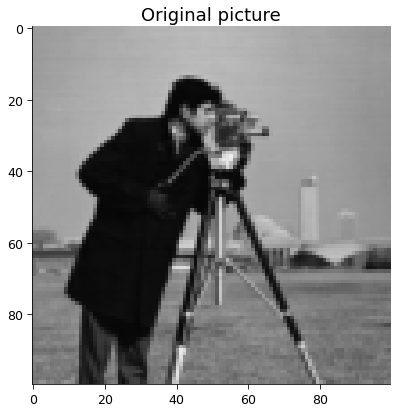

In [2]:
from skimage import io, data, transform
img = data.camera()
original = transform.resize(img, (100,100))
io.imshow(original)
plt.title('Original picture')

## Network dynamics
$$
\tau \frac{d v_{i}}{d t} =-\left(v_{i}-V_{R}\right)+f \sum_{j=1}^{n} B_{i j} p_{j} +\frac{S}{N_{A}} \sum_{k=1 \atop k \neq i}^{m} A_{i k} \sum_{l} \delta\left(t-\tau_{k l}\right)
$$

In [3]:
from brian2 import *

real time: 3.86e+00s


Text(0, 0.5, 'Neuron Index')

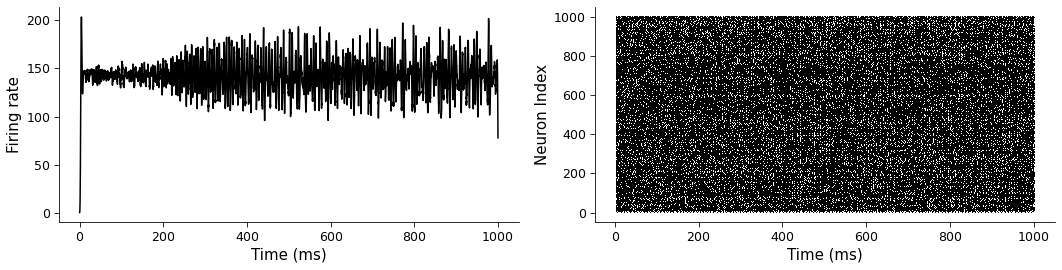

In [4]:
start_scope()

tau_m = 20*ms  # membrane time constant
V_th = 1       # normalized voltage threshold
V_rest = 0     # normalized resting potential
E_l = 0        # normalized leaky reversal potential

eqs = '''
dv/dt  = (-(v-E_l) + I_inj)/tau_m : 1 (unless refractory)
I_inj : 1
'''

P = NeuronGroup(1000, eqs, threshold='v>V_th', reset='v = V_rest', refractory=2*ms,
                 method='euler')
#P.v = 'V_rest + rand() * (V_th - V_rest)' # random voltage init
P.v = V_rest  # resting voltage init

# Connectivity matrix B: from receptor to sensory neurons
B = (np.random.rand(1000,10000)<0.001).astype(int)

receptor_input = original.flatten()

f_e = 1                         # feedforward strength
P.I_inj = f_e*B@receptor_input  # compressed linear projection to sensory neurons

# Connectivity matrix A: from sensory to sensory neurons
Na = 50
p = Na/1000    # connecting probability
x_A = np.random.rand(1000,1000)<p
x_A = x_A*(np.ones((1000,1000))-np.eye(1000))
j_A,i_A = x_A.nonzero()

S = 1             # effective total recurrent input to single sensory neuron
w_e = S/Na        # excitatory synaptic weight (voltage), EPSP

# connect
#C_A = Synapses(P, P, on_pre='v += w_e')
#C_A.connect(i=i_A, j=j_A)

# define state monitors
s_mon = SpikeMonitor(P)
p_mon = PopulationRateMonitor(P)

t0 = time.time()
run(1000 * msecond)
print(f'real time: {time.time()-t0:5.2e}s')

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(p_mon.t/ms, p_mon.smooth_rate(width=1*ms), 'k')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Firing rate')
ax[1].plot(s_mon.t/ms, s_mon.i, ',k')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neuron Index')

### calculate mean firing rate of network

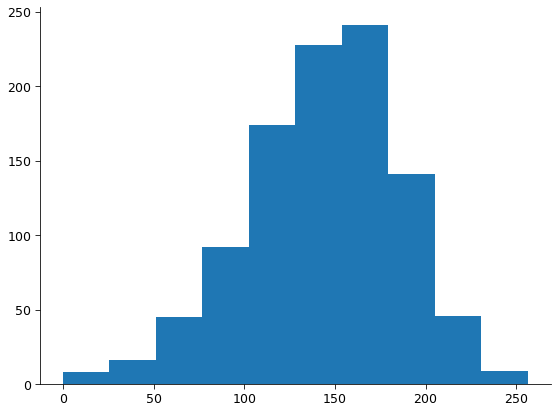

In [5]:
# calculate mean firing rate
mrate = np.array([np.sum((s_mon.t[s_mon.i==idx]/ms)>=200)/0.8 for idx in range(1000)])
# plot historgram of mean firing rate
fig_mrate = plt.hist(mrate)

## Solve a L-1 minimization problem

$$
f \sum_{j=1}^{n} B_{i j}(D \otimes D)_{i j}^{-1} \hat{p}_{j} =\left(\tau \mu_{i}+\frac{1}{2}\right)\left(V_{T}-V_{R}\right) -\frac{S}{N_{A}} \sum_{k=1 \atop k \neq i}^{m} A_{i k} \mu_{k}
$$

$$
\min_{\mathbf{y}}\sum_{j=1}^{n}|\hat{p}_j|
$$

You can simply adapt [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) model, i.e., linear model trained with L1 regularization, in scikit-learn module. For other algorithm solving L1 optimization, like OMP, you may check corresponding detailed [literatures](http://math.mit.edu/~liewang/OMP.pdf).

As for discrete cosine transformation, you may use [`dct`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html) and idct(for inverted dct) in fftpack of scipy package.

Also you can write you own version like this below:

for descrite cosine transform formulated as `dct`$(\mathbf{x}) = \left(D\otimes D\right)\mathbf{x} = \mathbf{y}$, we have

$$
y_{k}=f\cdot 2 \sum_{n=0}^{N-1} x_{n} \cos \left(\frac{\pi k(2 n+1)}{2 N}\right)
$$
where
$$
f=\left\{\begin{array}{ll}\sqrt{\frac{1}{4 N}} & \text { if } k=0 \\ \sqrt{\frac{1}{2 N}} & \text { otherwise }\end{array}\right.
$$

As for inverted descrite cosine transform formulated as `idct`$(\mathbf{x}) = \left(D\otimes D\right)^{-1}\mathbf{x} = \mathbf{y}$, we have

$$
y_{k}=\frac{x_0}{\sqrt{N}}+ \frac{2}{\sqrt{N}} \sum_{n=1}^{N-1} x_{n} \cos \left(\frac{\pi (2k+1)n}{2 N}\right)
$$

In [6]:
def my_dct_mat(n):
  j, i = np.meshgrid(np.arange(n), np.arange(n))
  D = np.sqrt(2/n)*np.cos(np.pi*i*(2*j+1)/(2*n))
  D[0,:] /= np.sqrt(2)
  return D

def my_idct_mat(n):
  j, i = np.meshgrid(np.arange(n), np.arange(n))
  D = np.sqrt(2/n)*np.cos(np.pi*(2*i+1)*j/(2*n))
  D[:,0] /= np.sqrt(2)
  return D

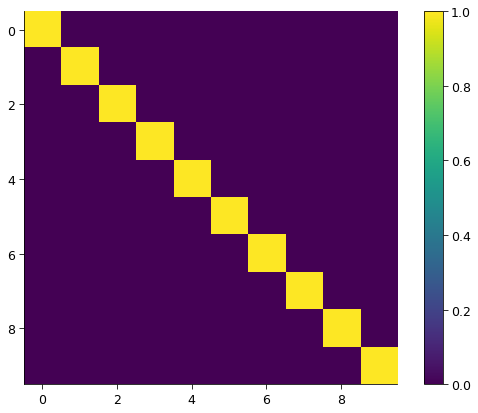

In [7]:
# verify your code
plt.imshow(my_dct_mat(10)@my_idct_mat(10))
plt.colorbar()

Compare the `dct` in scipy and our own `my_dct_mat`.

Text(0.5, 1.0, 'my_idct_mat')

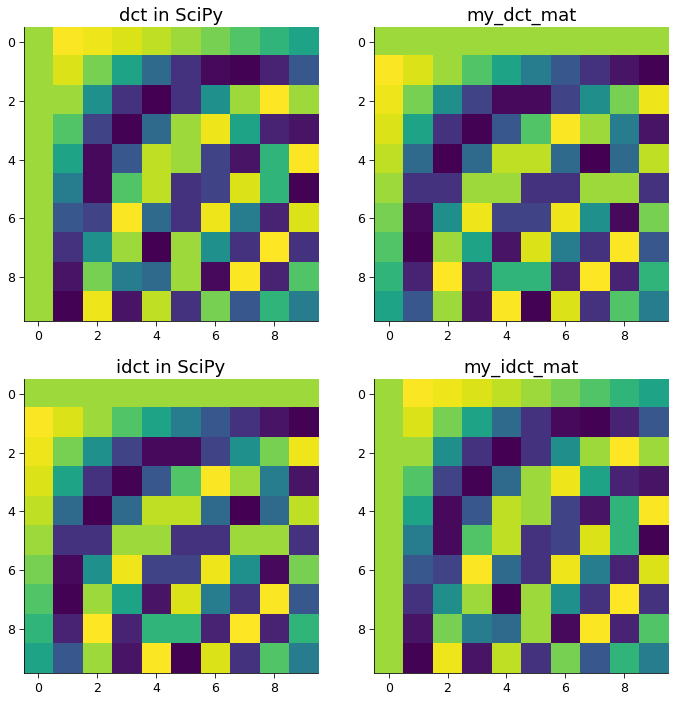

In [8]:
from scipy.fftpack import dct,idct
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0, 0].imshow(dct(np.eye(10), norm='ortho'))
ax[0, 1].imshow(my_dct_mat(10))
ax[0, 0].set_title('dct in SciPy')
ax[0, 1].set_title('my_dct_mat')

ax[1, 0].imshow(idct(np.eye(10), norm='ortho'))
ax[1, 1].imshow(my_idct_mat(10))
ax[1, 0].set_title('idct in SciPy')
ax[1, 1].set_title('my_idct_mat')

### Solve the LASSO optimization problem

In [9]:
from scipy.fftpack import dct,idct
from sklearn.linear_model import Lasso
A = x_A.astype(float)
B = B.astype(float)
# calculate right hand side to constraints
rhs = (tau_m/second*mrate+0.5)*(V_th-V_rest) - w_e*A@mrate*0
print(f'S/N_A = {w_e:5.2e}')
# create LASSO object and do fitting
clf = Lasso(alpha=0.0005,max_iter=10000)
clf.fit(B@idct(np.eye(10000)).T, rhs)

S/N_A = 2.00e-02


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## Show reconstructioned picture

Reconstruction difference :  0.53491


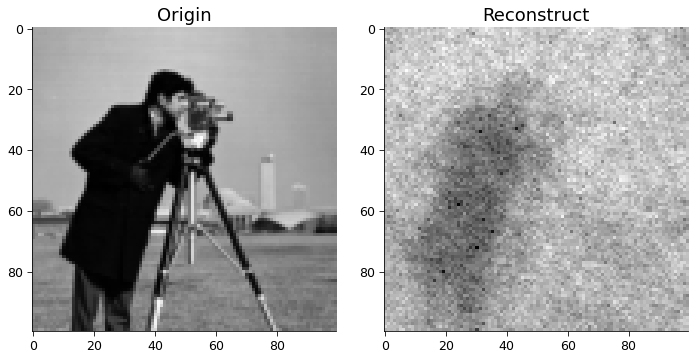

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(original, cmap='gray')
ax[0].set_title('Origin')
recon_img = np.reshape(idct(clf.coef_, norm='ortho'),(100,100))
ax[1].imshow(recon_img, cmap='gray')
ax[1].set_title('Reconstruct')
original_norm = original/original.max()
recon_img_norm = (recon_img+recon_img.min())/(recon_img.max()-recon_img.min())
get_norm = lambda x:np.sum(x**2)**(1/2)
print(f'Reconstruction difference : {(get_norm(original_norm)-get_norm(recon_img_norm))/get_norm(original_norm):8.5f}')

### Compare with direct linear mapping

In [11]:
linear_map = B@receptor_input

Reconstruction difference :  0.32700


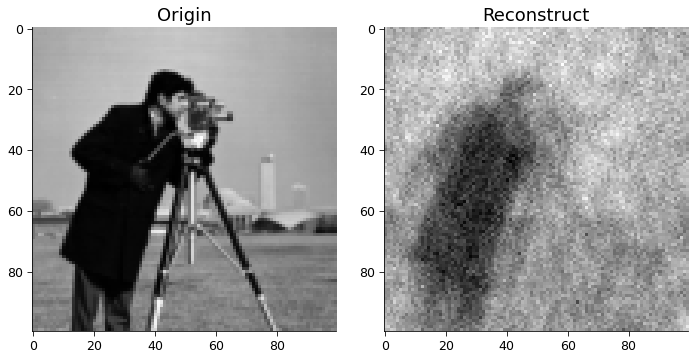

In [12]:
clf = Lasso(alpha=0.0001, max_iter=10000)
clf.fit(B@idct(np.eye(10000), norm='ortho').T, linear_map)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(original, cmap='gray')
ax[0].set_title('Origin')
recon_img_linear = np.reshape(idct(clf.coef_, norm='ortho'),(100,100))
ax[1].imshow(recon_img_linear, cmap='gray')
ax[1].set_title('Reconstruct')
recon_img_linear_norm = (recon_img_linear+recon_img_linear.min())/(recon_img_linear.max()-recon_img_linear.min())
print(f'Reconstruction difference : {(get_norm(original_norm)-get_norm(recon_img_linear_norm))/get_norm(original_norm):8.5f}')